In [116]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import sys
import importlib
import time
import gc
gc.collect()

sys.path.append('/sdf/home/j/johntw/dev')
import johntw_utils as jtw

sys.path.append('/sdf/home/j/johntw/FERMI/')
import Constants as c
import RunInfo as RI
import ECalibSupportFunctions as SF
import CovSupportFunctions as CSF

for i in [c, RI, SF, CSF, jtw]:
    importlib.reload(i)

run_info = RI.load_run_info()

In [2]:
run = 272

info = run_info[run]
sample = info['sample']
harmonics = info['harmonics']

In [3]:
with h5py.File(f'/sdf/scratch/lcls/ds/tmo/tmol1043723/scratch/jtw/pf_run{run}.h5', 'r') as fh:
    pf = {}
    print('Keys in h5 file:')
    for key in fh:
        print(f'\t{key}')
        pf[key] = fh[key][...]

Keys in h5 file:
	TOF
	left_pad
	left_spec
	padres
	peaks_pad
	peaks_spec
	right_pad
	right_spec
	spectra


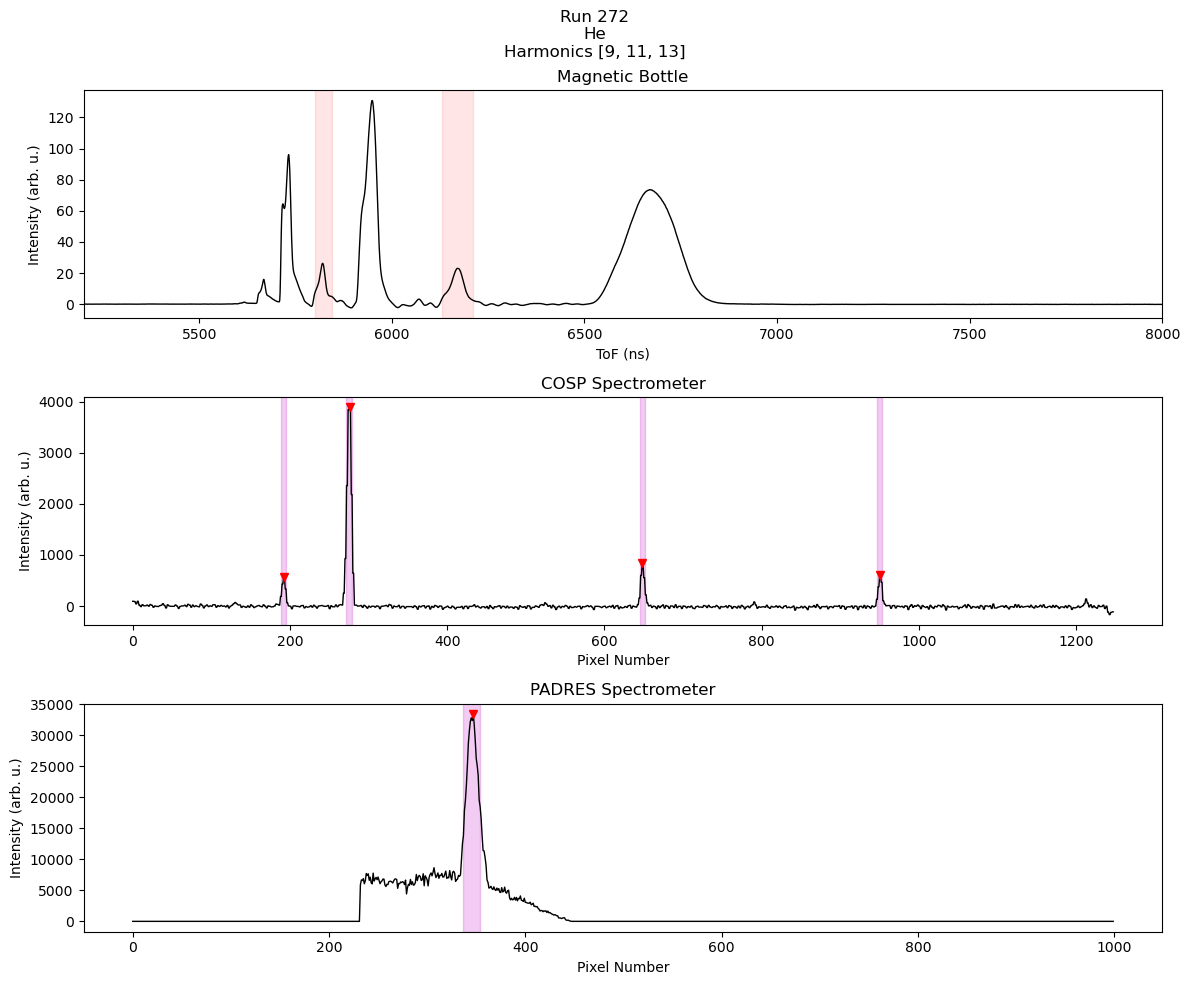

In [4]:
bins_spec = [[pf['left_spec'][i], pf['right_spec'][i]] for i in range(len(pf['left_spec']))]
bins_pad = [[pf['left_pad'][i], pf['right_pad'][i]] for i in range(len(pf['left_pad']))]


plt.figure(figsize=(12,10))

plt.subplot(3,1,1)
plt.plot(pf['TOF'], c='k', linewidth=1)

if sample == 'CO2':
    for i, col in zip(['X', 'A', 'B', 'C'], ['r', 'm', 'g', 'b']):
        if info['bins'][i] is not None:
            for k, j in enumerate(info['bins'][i]):
                if k == 0:
                    plt.axvspan(*j, color=col, alpha=0.1, label=i)
                else:
                    plt.axvspan(*j, color=col, alpha=0.1)

    plt.legend(loc='right', bbox_to_anchor=(1.1,0.5))
else:
    if info['bins']['Other'] is not None:
        for k, j in enumerate(info['bins']['Other']):
                plt.axvspan(*j, color='r', alpha=0.1)

plt.xlim([5200,8000])
plt.xlabel('ToF (ns)')
plt.ylabel('Intensity (arb. u.)')
plt.title('Magnetic Bottle')

plt.subplot(3,1,2)
plt.plot(pf['spectra'], lw=1, c='k')
for b in bins_spec:
    plt.axvspan(*b, 0, 1000, color='m', alpha=0.2)
plt.plot(pf['peaks_spec'], pf['spectra'][pf['peaks_spec']], 'rv')
plt.title('COSP Spectrometer')
plt.xlabel('Pixel Number')
plt.ylabel('Intensity (arb. u.)')

plt.subplot(3,1,3)
plt.plot(pf['padres'], lw=1, c='k')
for b in bins_pad:
    plt.axvspan(*b, 0, 1000, color='m', alpha=0.2)
plt.plot(pf['peaks_pad'], pf['padres'][pf['peaks_pad']], 'rv')
plt.title('PADRES Spectrometer')
plt.xlabel('Pixel Number')
plt.ylabel('Intensity (arb. u.)')

plt.suptitle(f'Run {run}\n{sample}\nHarmonics {harmonics}')
plt.tight_layout()
plt.show()

In [117]:
runs = np.arange(272, 286)
runs = np.array([i for i in runs if i not in RI.exclude])

ops = {}

for i, run in enumerate(runs):
    #Load in your data
    with h5py.File(f'/sdf/scratch/lcls/ds/tmo/tmol1043723/scratch/jtw/op_run{run}.h5', 'r') as fh:
        op = {}
        if i == 0:
            print('Keys in h5 file:')
        for key in fh:
            if i == 0:
                print(f'\t{key}')
            op[key] = fh[key][...]
    
        op['cDD'] = jtw.op2cov(op['DtD'],op['D'], op['D'])
        op['cDI'] = jtw.op2cov(op['DtI'], op['D'], op['I'])
        op['cII'] = jtw.op2cov(op['ItI'], op['I'], op['I'])
        op['pDD'] = op['cDD'] - op['cDI'] @ (np.linalg.inv(op['cII']) @ op['cDI'].T)
    
    tof_axis = op['tof_axis']

    #Calculate Downbinned Partial Correlation
    if sample == 'CO2':
        for i in ['X', 'A', 'B', 'C']:
            if info['bins'][i] is not None:
                for k, j in enumerate(info['bins'][i]):
                    inds = np.where((tof_axis > j[0]) & (tof_axis < j[-1]))[0]
                    slice_temp = slice(inds[0], inds[-1])
                    diag = np.array([op['pDD'][z,z] for z in range(op['pDD'].shape[0])])
                    diag_op = diag[:, None] * diag[None, :]
                    op_sum = np.mean(op['pDD'][slice_temp], axis=0)
                    diag_op_sum = np.mean(diag_op[slice_temp], axis=0)
                    op[f'pDD_{k}'] = op_sum/np.sqrt(diag_op_sum)             
    else:
        if info['bins']['Other'] is not None:
            slices = []
            for k, j in enumerate(info['bins']['Other']):
                    inds = np.where((tof_axis > j[0]) & (tof_axis < j[-1]))[0]
                    slice_temp = slice(inds[0], inds[-1])
                    slices.append(slice_temp)
                    diag = np.array([op['pDD'][z,z] for z in range(op['pDD'].shape[0])])
                    diag_op = diag[:, None] * diag[None, :]
                    op_sum = np.mean(op['pDD'][slice_temp], axis=0)
                    diag_op_sum = np.mean(diag_op[slice_temp], axis=0)
                    op[f'pDD_{k}'] = op_sum/np.sqrt(diag_op_sum)    

    ops[run] = op

Keys in h5 file:
	D
	DtD
	DtI
	I
	ItI
	n
	phases
	tof_axis


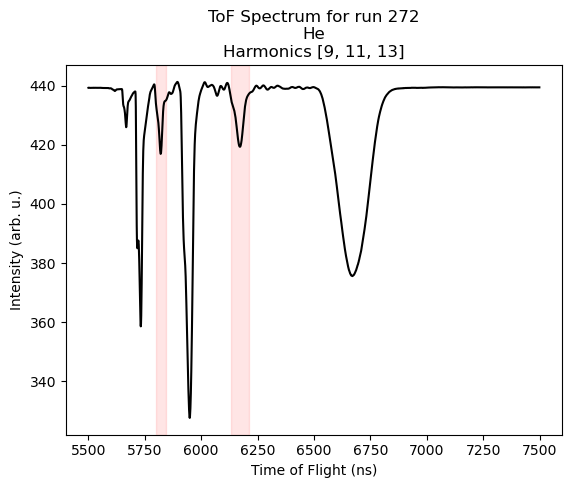

In [118]:
plt.plot(ops[runs[0]]['tof_axis'], ops[runs[0]]['D'], '-k')

if sample == 'CO2':
    for i, col in zip(['X', 'A', 'B', 'C'], ['r', 'm', 'g', 'b']):
        if info['bins'][i] is not None:
            for k, j in enumerate(info['bins'][i]):
                if k == 0:
                    plt.axvspan(*j, color=col, alpha=0.1, label=i)
                else:
                    plt.axvspan(*j, color=col, alpha=0.1)

    plt.legend(loc='right', bbox_to_anchor=(1.1,0.5))
else:
    if info['bins']['Other'] is not None:
        for k, j in enumerate(info['bins']['Other']):
                plt.axvspan(*j, color='r', alpha=0.1)
            
plt.xlabel('Time of Flight (ns)')
plt.ylabel('Intensity (arb. u.)')
plt.title(f'ToF Spectrum for run {runs[0]}\n{sample}\nHarmonics {harmonics}')
plt.show()

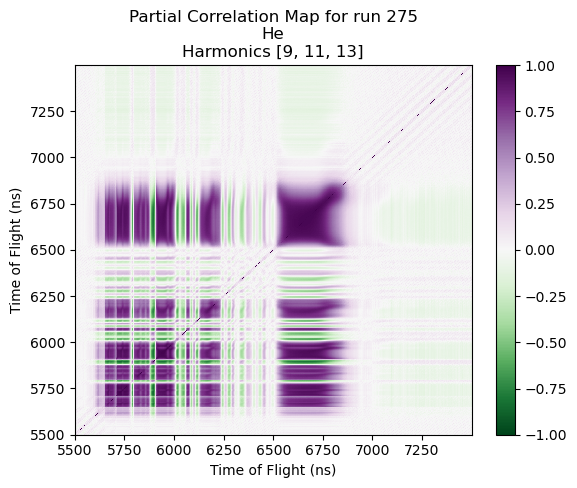

In [119]:
plt.pcolormesh(tof_axis, tof_axis, jtw.cov2corr(ops[runs[2]]['pDD']), cmap='PRGn_r')
plt.clim([-1,1])
plt.xlabel('Time of Flight (ns)')
plt.ylabel('Time of Flight (ns)')
plt.title(f'Partial Correlation Map for run {runs[2]}\n{sample}\nHarmonics {harmonics}')
plt.colorbar()
plt.show()

In [120]:
print(ops[272].keys())

dict_keys(['D', 'DtD', 'DtI', 'I', 'ItI', 'n', 'phases', 'tof_axis', 'cDD', 'cDI', 'cII', 'pDD', 'pDD_0', 'pDD_1'])


In [121]:
phases = np.zeros_like(runs, dtype='float64')

if sample == 'CO2':
    pcorr_concat_0 = np.zeros((4, runs.shape[0], tof_axis.shape[0]))
    pcorr_concat_1 = np.zeros((4, runs.shape[0], tof_axis.shape[0]))
else:
    pcorr_concat_0 = np.zeros((runs.shape[0], tof_axis.shape[0]))
    pcorr_concat_1 = np.zeros((runs.shape[0], tof_axis.shape[0]))

for i, run in enumerate(runs):
    phases[i] = ops[run]['phases'][run_info[run]['ps']-3]
    if sample == 'CO2':
        for j, k in enumerate(['X', 'A', 'B', 'C']):
            pcorr_concat_0[j][i] = ops[run][f'pDD_{k}_0']
            pcorr_concat_1[j][i] = ops[run][f'pDD_{k}_1']
    else:
        pcorr_concat_0[i] = ops[run]['pDD_0']
        pcorr_concat_1[i] = ops[run]['pDD_1']

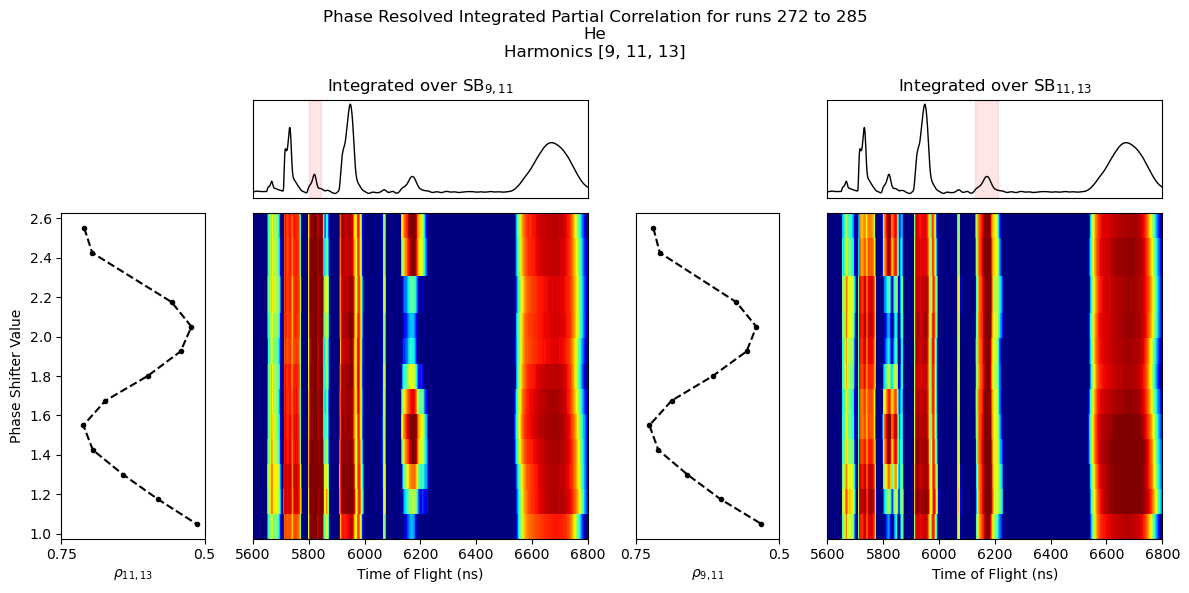

In [122]:
climits = [0.5, 0.75]
tof_limits = [5600, 6800]

if sample == 'CO2':
    pass
else:
    plt.figure(figsize=(12,6))
    grid = plt.GridSpec(4,6)

    plt.subplot(grid[0,1:3])
    plt.plot(pf['TOF'], c='k', linewidth=1)    

    if info['bins']['Other'] is not None:
        for k, j in enumerate(info['bins']['Other']):
                if k == 0:
                    plt.axvspan(*j, color='r', alpha=0.1)
    
    plt.title('Integrated over SB$_{{{},{}}}$'.format(harmonics[0],harmonics[1]))
    plt.xticks([])
    plt.yticks([])
    plt.xlim(*tof_limits)

    plt.subplot(grid[0,4:])
    plt.plot(pf['TOF'], c='k', linewidth=1)

    if info['bins']['Other'] is not None:
        for k, j in enumerate(info['bins']['Other']):
                if k == 1:
                    plt.axvspan(*j, color='r', alpha=0.1)
    
    plt.xlim(*tof_limits)
    plt.xticks([])
    plt.yticks([])
    plt.title('Integrated over SB$_{{{},{}}}$'.format(harmonics[1],harmonics[2]))

    plt.subplot(grid[1:,0])
    plt.plot(np.mean(pcorr_concat_0[:,slices[1]], axis=1),phases, 'k.--')
    plt.xticks(climits,climits)
    plt.gca().invert_xaxis()
    plt.ylabel('Phase Shifter Value', rotation=90)
    plt.xlabel(r'$\rho_{{{},{}}}$'.format(harmonics[1],harmonics[2]))

    plt.subplot(grid[1:,3])
    plt.plot(np.mean(pcorr_concat_1[:,slices[0]], axis=1),phases, 'k.--')
    plt.xticks(climits,climits)
    plt.gca().invert_xaxis()
    plt.yticks([])
    plt.xlabel(r'$\rho_{{{},{}}}$'.format(harmonics[0],harmonics[1]))

    plt.subplot(grid[1:,1:3])
    plt.pcolormesh(tof_axis, phases, pcorr_concat_0, cmap='jet')
    plt.clim(*climits)
    plt.xlabel('Time of Flight (ns)')
    plt.yticks([])
    plt.xlim(*tof_limits)

    plt.subplot(grid[1:,4:])
    plt.pcolormesh(tof_axis, phases, pcorr_concat_1, cmap='jet')
    plt.clim(*climits)
    plt.xlabel('Time of Flight (ns)')
    plt.yticks([])
    plt.xlim(*tof_limits)

    plt.suptitle(f'Phase Resolved Integrated Partial Correlation for runs {runs[0]} to {runs[-1]}\n{sample}\nHarmonics {harmonics}')
    plt.tight_layout()
    plt.show()
